# TP1: Data Exploration

## Winter 2023 - BIN710 Data Mining (UdeS)

First assignement as part of the Data Mining class at UdeS.

Student name : Simon Lalonde

### Directory structure

├── TP1_data.csv    ---> Data

├── tp1.ipynb   ---> Jupyter Notebook

└── TP1.pdf    ---> Tasks to complete

### Metadata
csv file with :
- 59 objects
- 4 features
- 3 classes (as factors)

### Goal
Are all 4 features relevant for a classification task. The classifier will be distance based (KNN with K=5 or nearest centroid classifier)

### 1. Data Representation

In [733]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy.stats import shapiro 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestCentroid

Read, inspect and check for inconsistencies

In [734]:
datafile = Path("TP1_data.csv")
df = pd.read_csv(datafile, index_col=0)
df.head()

,attribut1,attribut2,attribut3,attribut4,classe
id1,38.0,33.0,10.0,19.0,0
id2,38.2,23.4,17.0,16.6,0
id3,33.0,24.0,19.0,23.0,0
id4,31.0,21.0,29.0,16.0,0
id5,37.0,27.0,24.0,12.0,0


In [735]:
# Check types, NaN or negative data
print(f"Data types : {np.unique(df.dtypes.to_list())}") # types

print(f"Number of rows with any NaN : {len(df.isna().any()[df.isna().any()])}") #NaN

# Check for neg data
print(f"Number of cols with negative values : {len((df < 0).any()[(df < 0).any()].index)}") # Negative vals

Data types : [dtype('int64') dtype('float64')]
Number of rows with any NaN : 0
Number of cols with negative values : 0


In [736]:
# Extracting features
cols = df.columns.to_list()
features = cols[:-1]
print(features)

['attribut1', 'attribut2', 'attribut3', 'attribut4']


In [737]:
# Separating features and classes
X = df[features]
y = df["classe"]

#### a) Evaluate correlations and possible transformations

Check correlations between features and then comparing between classes

In [738]:
# Check distributions
def get_distributions(data, features, plt_rows, plt_cols, feat_color=True, hue=None, bins='auto', binwidth=None, kde=True):
    # Square subplots
    fig, axes = plt.subplots(plt_rows, plt_cols, figsize=(8,10))
    axes = axes.ravel()

    for i, feat in enumerate(features):
        if feat_color:
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=sns.color_palette()[i])
        else :
            feat_color = None
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=feat_color)
        plot.set(title=f"Distribution for : {feat}")
        plot.set(xlabel="")

    fig.tight_layout()


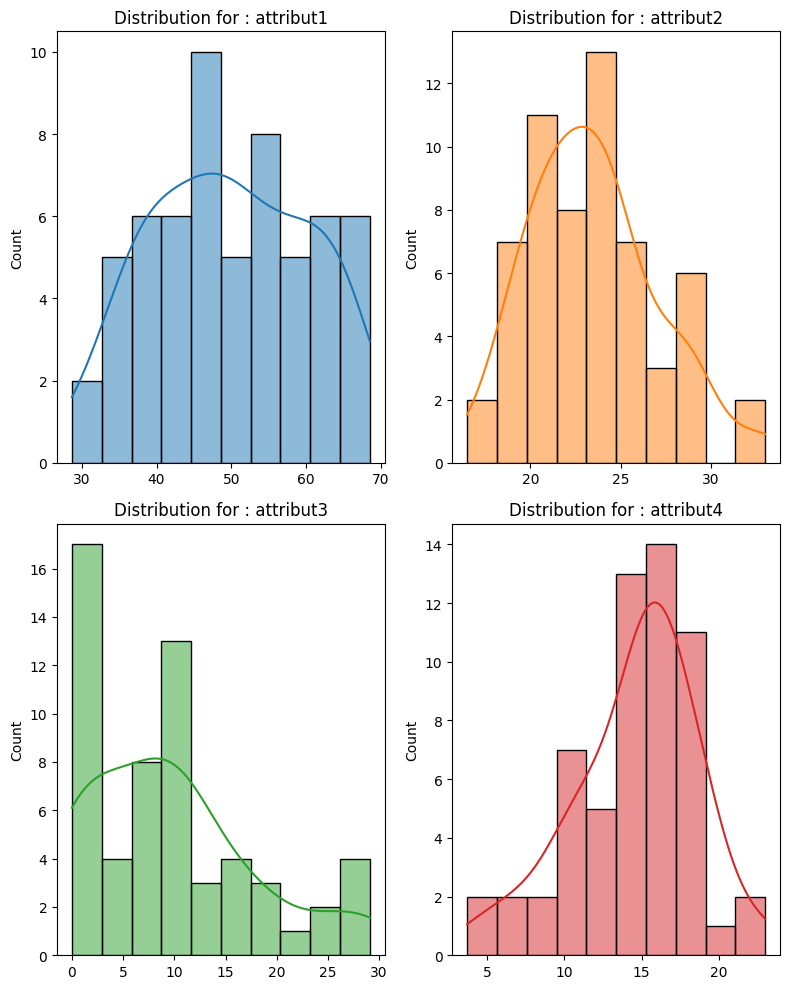

In [739]:
# Check distributions
get_distributions(X, features, 2, 2, bins=10, kde=True)


attribut1,2 and 4 seem normally distributed while 3 is more spread out (in kurtosis terms)

In [740]:
def check_normality(df, features):
    for feat in features:
        norm = shapiro(df[feat])
        if norm.pvalue < 0.05:
            print(f"{feat} is not normally distributed since pval={norm.pvalue} < 0.05")
        else:
            print(f"{feat} follows a normal distribution (null hypothesis)")

In [741]:
# Check for normality 
check_normality(X, features)

attribut1 follows a normal distribution (null hypothesis)
attribut2 follows a normal distribution (null hypothesis)
attribut3 is not normally distributed since pval=0.00028542501968331635 < 0.05
attribut4 follows a normal distribution (null hypothesis)


**Check dispersions measures**

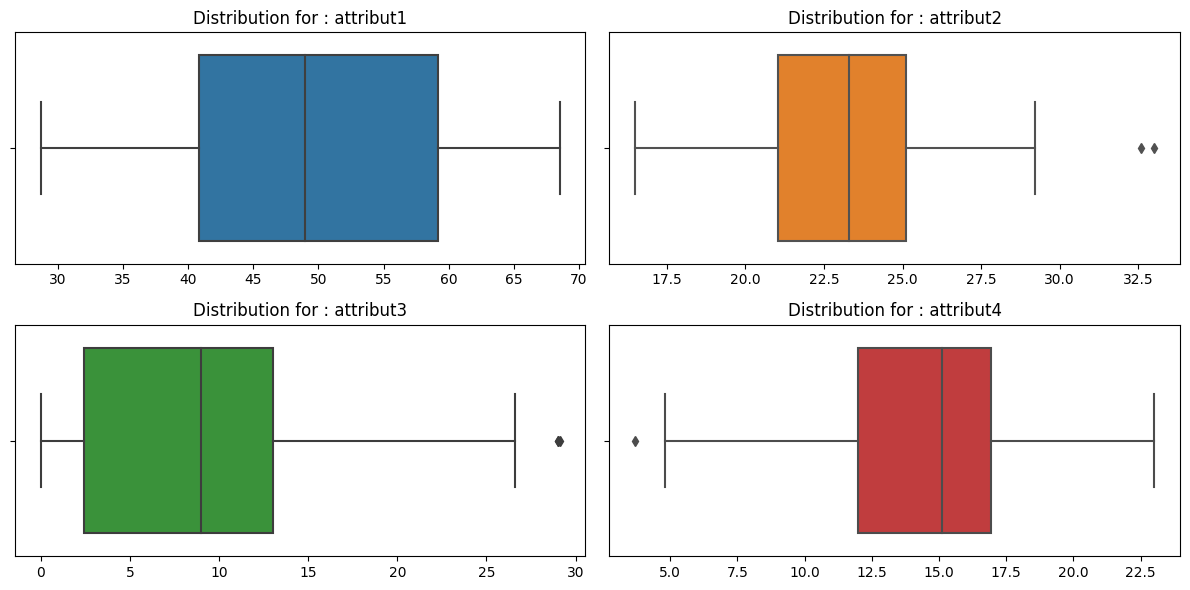

In [742]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
axes = axes.ravel()

for i, feat in enumerate(features):
    plot = sns.boxplot(data=df, x=feat, ax=axes[i], color=sns.color_palette()[i])
    plot.set(title=f"Distribution for : {feat}")
    plot.set(xlabel="")

fig.tight_layout()

<AxesSubplot: >

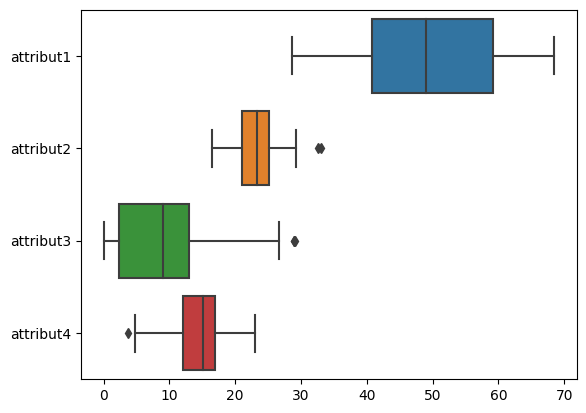

In [743]:
sns.boxplot(data=df[features], orient="h")

In [744]:
def get_dispersions(df, features):
    for feat in features:
        mean = np.mean(df[feat])
        median = np.median(df[feat])
        sd = np.std(df[feat])
        print(f"For feature {feat} : Mean={mean:.2f}, Median={median:.2f}, Std_dev={sd:.2f}")

In [745]:
get_dispersions(X, features)

For feature attribut1 : Mean=49.79, Median=49.00, Std_dev=10.40
For feature attribut2 : Mean=23.49, Median=23.30, Std_dev=3.50
For feature attribut3 : Mean=9.59, Median=9.00, Std_dev=8.11
For feature attribut4 : Mean=14.56, Median=15.10, Std_dev=4.02


We see a few outliers and some distributions are narrower than others

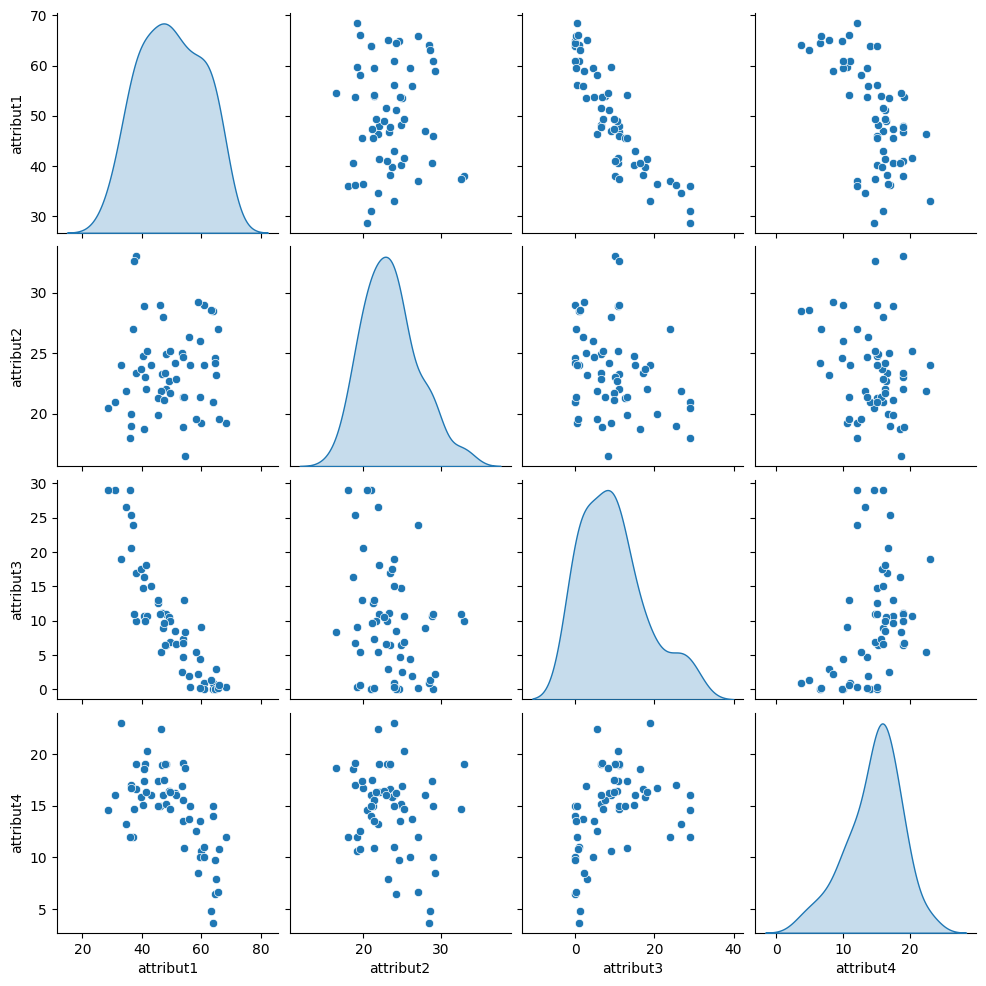

In [746]:
# Pairplot for features
g = sns.pairplot(X, diag_kind="kde")

g.tight_layout();

From the pairplot feature comparisons, we can say : 
- attribut1 and attribut3 seem inversely correlated
- attribut 1 and attribut 4 seem weakly inversely correlated 

In [747]:
# Pearson correlation
X.corr(method="pearson")

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,0.017056,-0.890974,-0.622651
attribut2,0.017056,1.000000,-0.258163,-0.242347
attribut3,-0.890974,-0.258163,1.000000,0.372298
attribut4,-0.622651,-0.242347,0.372298,1.000000


In [748]:
# Check with other correlation coefficients for non-normal attribut3
X.corr(method="spearman")

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,0.057114,-0.907870,-0.582645
attribut2,0.057114,1.000000,-0.229549,-0.212478
attribut3,-0.907870,-0.229549,1.000000,0.450973
attribut4,-0.582645,-0.212478,0.450973,1.000000


Distributions for each feature per class

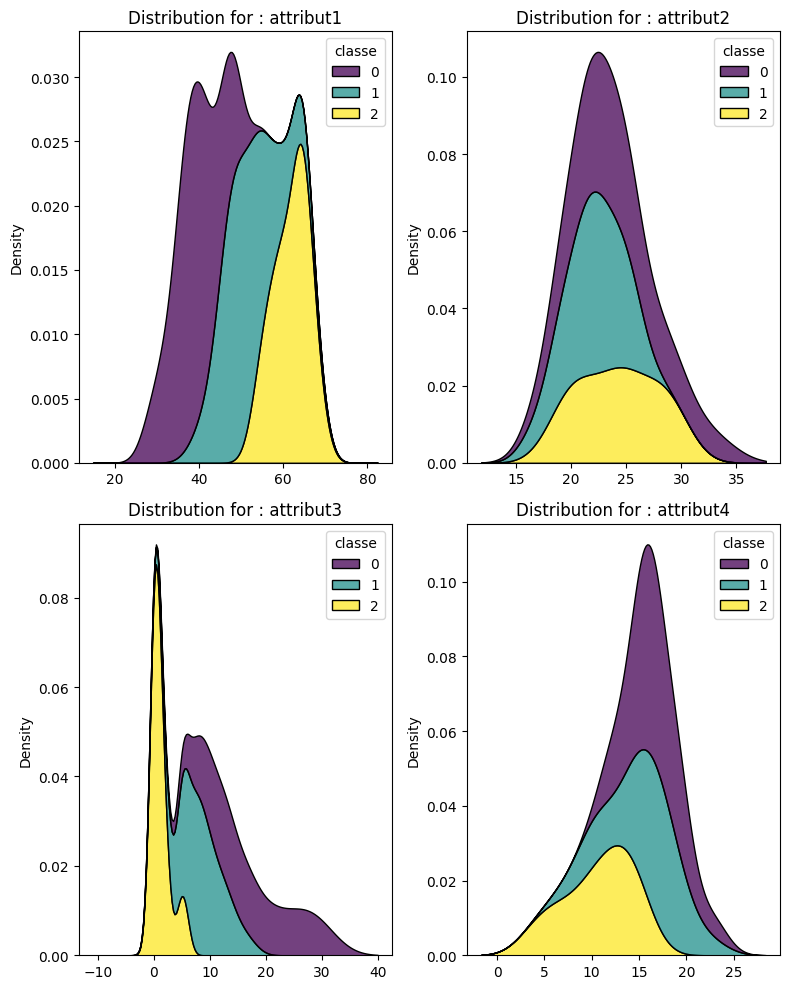

In [749]:
plt_rows = 2
plt_cols = 2

fig, axes = plt.subplots(plt_rows, plt_cols, figsize=(8,10))
axes = axes.ravel()

for i, feat in enumerate(features):
    plot = sns.kdeplot(data=df, x=feat, ax=axes[i], hue="classe", multiple="stack", palette="viridis")
    plot.set(title=f"Distribution for : {feat}")
    plot.set(xlabel="")

fig.tight_layout()

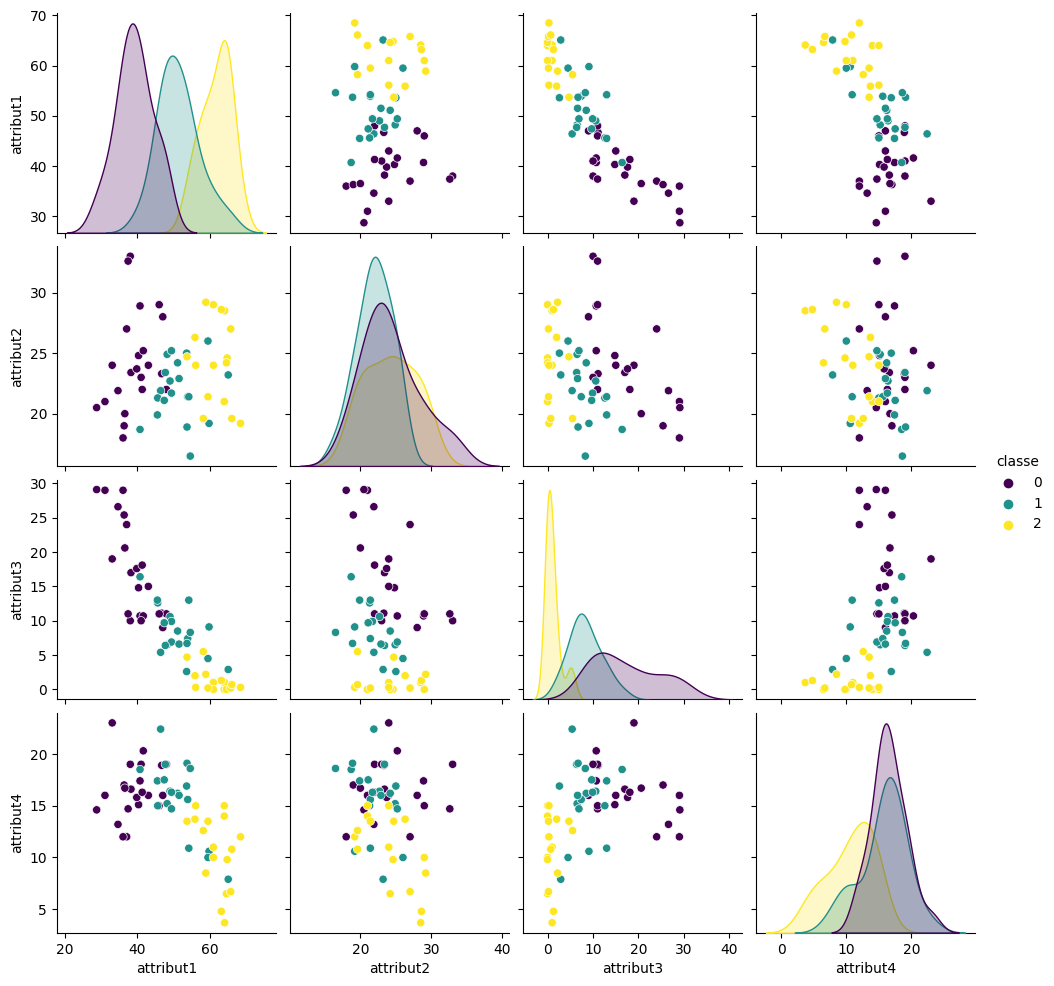

In [750]:
# Pairplot for features
g = sns.pairplot(df, diag_kind="kde", hue="classe", palette="viridis")

g.tight_layout();

PCA will probably reduce the correlation between combinations of attribut1-3 and attribut1-4 thus the classification model would probably benefit from PCA. 

However, since we do not have a lot of features (4D can still be visualized without dimensionality reduction) I don't think it is necessary since passing from 4 to either 1, 2 or 3 dimensions and the gain in model performance might not be better.

b) We will perform PCA, choose a right number of components to keep and visualize the data post transformation

In [751]:
def plot_explained_variance(data, n_components):
    # Calculate cumulated variance
    pca = PCA(n_components=n_components).fit(data)
    cumul = []
    tot = 0
    for i in pca.explained_variance_ratio_:
        cumul.append(i+tot)
        tot += i
    # Plot
    n_compo = np.arange(1, pca95.n_components_+1)
    plt.figure()
    plt.plot(n_compo, cumul, marker="o")
    plt.axhline(y=n_components, color="black", linestyle="--" )
    plt.legend(["Cumulative explained variance", "% variance explained"])
    return pca

Number of components to keep for PCA according to Kaiser's_rule : 3


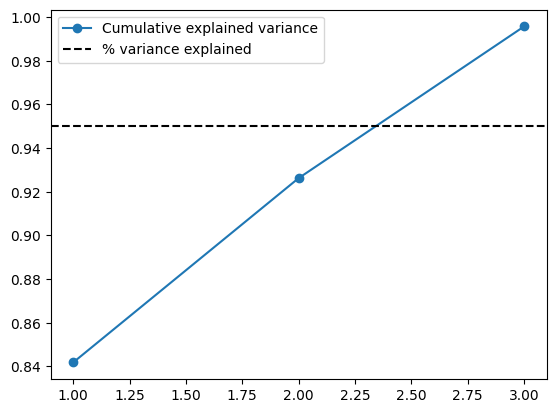

In [752]:
# 95% variance explained
pca95 = plot_explained_variance(X, 0.95)
kaiser_rule = len([i for i in (pca95.explained_variance_ > 1) if i==True])
print(f"Number of components to keep for PCA according to Kaiser's_rule : {kaiser_rule}")

Number of components to keep for PCA according to Kaiser's_rule : 3


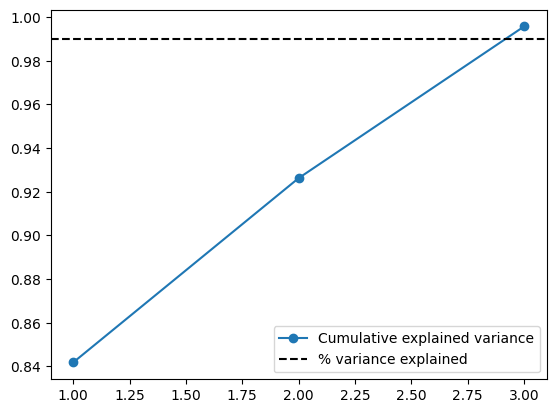

In [753]:
# 99% variance explained
pca99 = plot_explained_variance(X, 0.99)
kaiser_rule = len([i for i in (pca99.explained_variance_ > 1) if i==True])
print(f"Number of components to keep for PCA according to Kaiser's_rule : {kaiser_rule}")

- To capture 95% to 99 of the variance explained we would need 3 components
- Since the explained variance after dimension reduction to 1, 2, 3 dimension dimension are > 1 : 3 components

**Caclulate nearest centroids (using Eucledian distance) for each objects with n_components = 2 and 3 and compare with truth**

In [754]:
# Fit the model for 2/3 PC
pca_2c = PCA(n_components=2).fit(X)
pca_3c = PCA(n_components=3).fit(X)

In [755]:
# Dimensionality reduction 2/3 PC
data2d = pca_2c.transform(X)
data3d = pca_3c.transform(X)
# with y as our classes

**Considering  that PCA scores are centered at zero, it means their euclidean distance to the centroid is basically the array itself.**

In [756]:

print(f"pca_2c centroid : {np.mean(data2d, dtype='float64')}")
print(f"pca_2c centroid : {np.mean(data3d, dtype='float64')}")

pca_2c centroid : -5.758105856530473e-16
pca_2c centroid : 3.2114925910061025e-16


We can calculate the distance to the centroids by :
1. grouping by class
2. calculating the mean
3. The square root of the substraction the value of transformed (or not) datapoint to the mean to the power of 2
4. We can also calculate the manhattan distance by retrieving the absolute value from the substraction of the point to the mean

For PCA with 2-dimensions

In [757]:
#TODO MANHATTAN

In [758]:
# Centroids
pca2c_df = pd.DataFrame(data2d, columns=["pc1","pc2"])
pca2c_df["real_class"] = y.values
pca2c_df.groupby("real_class").mean()

,pc1,pc2
real_class,,
0,13.189847,0.624828
1,-1.671420,-0.087523
2,-15.102837,-0.705632


In [759]:
# Euclidian distances
pca2c_euc = pca2c_df.groupby("real_class").transform(lambda x: (x - x.mean())**2)
pca2c_euc["euc"] = np.sqrt(pca2c_euc["pc1"] + pca2c_euc["pc2"])
pca2c_euc = pca2c_euc.drop(columns=["pc1", "pc2"])
pca2c_euc["real_class"] = y.values 
pca2c_euc.head()

,euc,real_class
0,11.099564,0
1,0.671727,0
2,8.159621,0
3,14.685877,0
4,6.163711,0


Text(0.5, 0.98, 'Distributions for euclidian distances with PCA 2-dimensions')

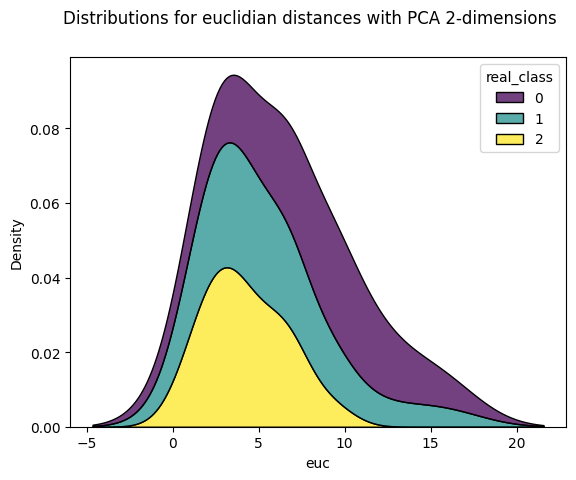

In [760]:
fig = plt.figure()
sns.kdeplot(data=pca2c_euc, x="euc", hue="real_class", multiple="stack", palette="viridis")
fig.suptitle("Distributions for euclidian distances with PCA 2-dimensions")

For PCA with 3-dimensions

In [761]:
# Centroids
pca3c_df = pd.DataFrame(data3d, columns=["pc1","pc2", "pc3"])
pca3c_df["real_class"] = y.values
pca3c_df.groupby("real_class").mean()

,pc1,pc2,pc3
real_class,,,
0,13.189847,0.624828,1.165324
1,-1.671420,-0.087523,-2.162568
2,-15.102837,-0.705632,1.036132


In [762]:
# Euclidian distances
pca3c_euc = pca3c_df.groupby("real_class").transform(lambda x: (x - x.mean())**2)
pca3c_euc["euc"] = np.sqrt(pca3c_euc["pc1"] + pca3c_euc["pc2"] + pca3c_euc["pc3"])
pca3c_euc = pca3c_euc.drop(columns=["pc1", "pc2", "pc3"])
pca3c_euc["real_class"] = y.values 
pca3c_euc.head()

,euc,real_class
0,11.626925,0
1,0.920608,0
2,9.055632,0
3,14.691659,0
4,8.733600,0


Text(0.5, 0.98, 'Distributions for euclidian distances with PCA 3-dimensions')

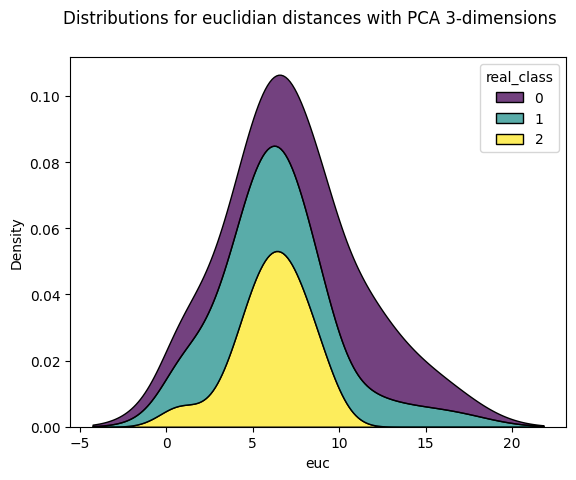

In [763]:
fig = plt.figure()
sns.kdeplot(data=pca3c_euc, x="euc", hue="real_class", multiple="stack", palette="viridis")
fig.suptitle("Distributions for euclidian distances with PCA 3-dimensions")

For untransformed data

In [764]:
# Centroids
df.groupby("classe").mean()

,attribut1,attribut2,attribut3,attribut4
classe,,,,
0,39.186364,24.286364,17.259091,16.527273
1,51.315000,21.975000,8.350000,15.710000
2,61.729412,24.229412,1.141176,10.652941


In [765]:
# Euclidian distances
df_euc = df.groupby("classe").transform(lambda x: (x - x.mean())**2)
df_euc["euc"] = np.sqrt(df_euc["attribut1"] + df_euc["attribut2"] + df_euc["attribut3"] + df_euc["attribut4"])
df_euc = df_euc.drop(columns=features)
df_euc["real_class"] = y.values 
df_euc.head()

,euc,real_class
id1,11.668063,0
id2,1.353134,0
id3,9.125791,0
id4,14.695023,0
id5,8.836292,0


Text(0.5, 0.98, 'Distributions for euclidian distances with PCA 3-dimensions')

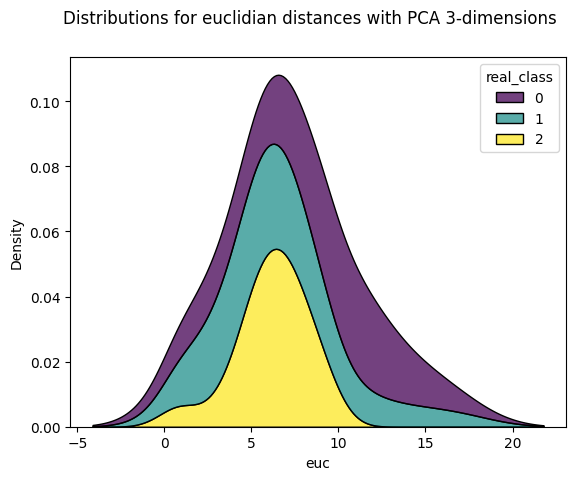

In [766]:
fig = plt.figure()
sns.kdeplot(data=df_euc, x="euc", hue="real_class", multiple="stack", palette="viridis")
fig.suptitle("Distributions for euclidian distances with PCA 3-dimensions")

**If we compare the distributions between Euclidian distances for dimension-reduced transformed data PCA (2D) or PCA (3D) vs untransformed data, we distributions is more skewed with 2PC**

**Since we know that attribut1 has large distribution and is correlated with att3 and 4, we might benefit from using the mahalanobis distance**

Another way to calculate the distance from centroids (euclidian distance) and calculate the accuracy of the classifier with different no dim-reduction or n_PC2 or n_PC3 by using the NearestCentroid classifier

In [767]:
from sklearn.inspection import DecisionBoundaryDisplay

In [768]:
def plot_nearest_centroids(data, clf):
    plt.figure()
    DecisionBoundaryDisplay.from_estimator(clf, data[:, :2], response_method="predict", alpha=0.5)
    plt.scatter(data[:, 0], data[:,1], marker=".", s=100, c=y, edgecolors="k")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Nearest Centroid classification with 3 classes")
    plt.show()

In [769]:
# Nearest centroid classifier for 2PC
clf = NearestCentroid(metric="euclidean")
ncc = clf.fit(data2d, y)
y_pred = ncc.predict(data2d)

# Using the built-in accuracy in sklearn
print(f"Mean accuracy with PCA reduction to 2-dim : {ncc.score(data2d, y)}\n")
# Or numpy np.mean(y == y_pred)

print(f"Centroids values for 2dims : \n\n{ncc.centroids_}")

Mean accuracy with PCA reduction to 2-dim : 0.8305084745762712

Centroids values for 2dims : 

[[ 13.18984673   0.62482803]
 [ -1.67141988  -0.08752333]
 [-15.10283708  -0.70563236]]


<Figure size 640x480 with 0 Axes>

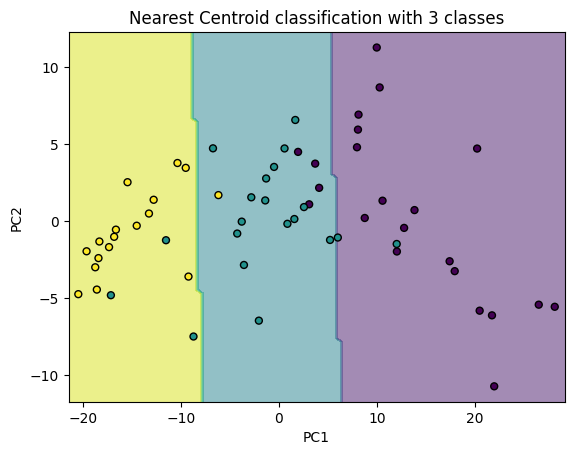

In [774]:
plot_nearest_centroids(data2d, ncc)

In [775]:
# Nearest centroid classifier for 3PC
clf = NearestCentroid(metric="euclidean")
ncc = clf.fit(data3d, y)
y_pred = ncc.predict(data3d)

# Using the built-in accuracy in sklearn
print(f"Mean accuracy with PCA reduction to 3-dim : {ncc.score(data3d, y)}\n")
# Or numpy np.mean(y == y_pred)

print(f"Centroids values for 3dims : \n\n{ncc.centroids_}")

Mean accuracy with PCA reduction to 3-dim : 0.847457627118644

Centroids values for 3dims : 

[[ 13.18984673   0.62482803   1.16532378]
 [ -1.67141988  -0.08752333  -2.16256844]
 [-15.10283708  -0.70563236   1.03613209]]


<Figure size 640x480 with 0 Axes>

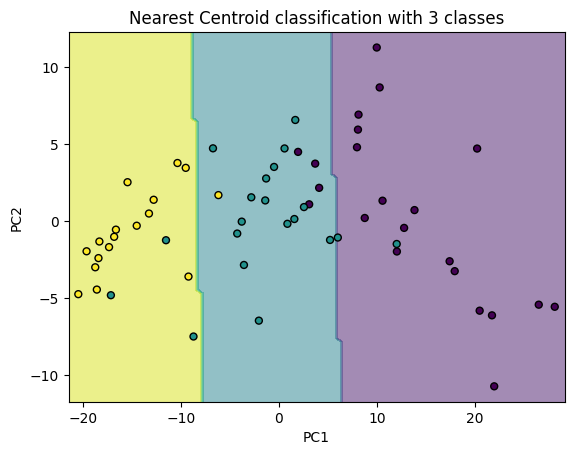

In [776]:
# for visualization of the 3PC (only first 2 PC of PCA-3dims)
clf = NearestCentroid(metric="euclidean")
ncc = clf.fit(data3d[:, :2], y)
y_pred = ncc.predict(data3d[:, :2])

plt.figure()
DecisionBoundaryDisplay.from_estimator(ncc, data3d[:, :2], response_method="predict", alpha=0.5)
plt.scatter(data3d[:, 0], data3d[:,1], marker=".", s=100, c=y, edgecolors="k")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Nearest Centroid classification with 3 classes")
plt.show()

In [777]:
# Nearest centroid classifier for 3PC
clf = NearestCentroid(metric="euclidean")
ncc = clf.fit(X, y)
y_pred = ncc.predict(X)

# Using the built-in accuracy in sklearn
print(f"Mean accuracy with no dimensionality reduction techniques : {ncc.score(X, y)}\n")
# Or numpy np.mean(y == y_pred)

print(f"Centroids values for original dataset :")

Mean accuracy with no dimensionality reduction techniques : 0.847457627118644

Centroids values for original dataset :


In [778]:
#Which is the same as calculating the mean per class : 
df.groupby("classe").mean()

,attribut1,attribut2,attribut3,attribut4
classe,,,,
0,39.186364,24.286364,17.259091,16.527273
1,51.315000,21.975000,8.350000,15.710000
2,61.729412,24.229412,1.141176,10.652941


**Accuracy is slightly better with n_components = 3 with PCA, but it does not improve our Nearest Centroid classifier model than when no dimensionality reduction is applied**

### Distance measure choice